In [1]:
%load_ext jupyternotify
import pennylane as qml 
from pennylane import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
n_wires = 4 #4 qubits 

dev = qml.device('default.qubit.tf', wires= n_wires)
dev1 = qml.device('default.qubit.tf', wires= n_wires)

In [3]:
#geneate the random 4 qubit statevector phi 
@qml.qnode(dev, interface="tf")
def phi_circ(weights): 
    
    for i in range(4):
        
        qml.RX(weights[i], wires=i)
        qml.RY(weights[4+i], wires=i)
        qml.RZ(weights[8+i], wires=i)
    
    return [qml.expval(qml.Identity(wires=i)) for i in range(n_wires)]


random  = tf.constant( np.random.uniform(0, 2*np.pi, 12)  )
phi_circ(random)
phi = tf.dtypes.cast(dev.state, tf.complex128)

In [4]:
#defined layer of odd and even blocks 
@qml.template
def layer(weights, wires):
    
    for i in range(4):   
        qml.RX(weights[i], wires=i)
        
    for i in range(4):    
        qml.RZ(weights[4+i], wires=i)
    
    qml.CZ(wires=[0,1])
    qml.CZ(wires=[0,2])
    qml.CZ(wires=[0,3])
    qml.CZ(wires=[1,2])
    qml.CZ(wires=[1,3])
    qml.CZ(wires=[2,3])


In [5]:
#make a qnode with the number of layers as a varying parameter 
#this generates the 4 qubit statevector psi 

@qml.qnode(dev1, interface="tf")    
def psi_circ(thetas): 

    for i in range(n_layers):
        layer(weights = thetas, wires= range(n_wires) )

    return [qml.expval(qml.Identity(wires=i)) for i in range(n_wires)]


In [6]:
#define the loss function which is to be minimised 
def eplison(thetas):
    
    psi_circ(thetas)
    psi = dev1.state
    
    e = tf.math.sqrt(tf.tensordot(tf.math.conj(psi - phi), psi - phi, axes=1))
    
    return tf.math.real(e)

Text(0, 0.5, 'Eplison')

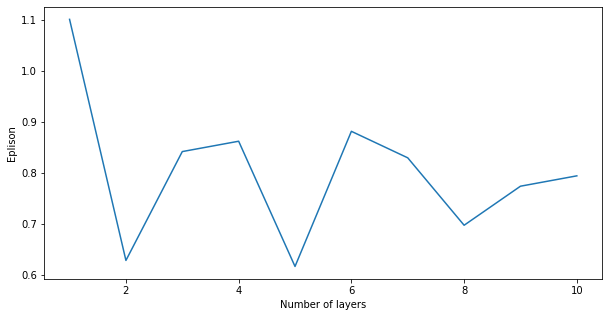

<IPython.core.display.Javascript object>

CPU times: user 10min 4s, sys: 214 ms, total: 10min 5s
Wall time: 10min 4s


In [7]:
%%time
%%notify

#answer to task 1

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

e = [] #minimum eplison 

#change the number of layers in each iteration 
for k in range(10):
    n_layers = k+1

    init_thetas = np.random.uniform(0, 2*np.pi, 8*n_layers)
    thetas = tf.Variable(init_thetas)

    eplison(thetas)

    diff_in_cost = [0,1] #initialise array with dummy values to start while loop 

    i = 0 
    while abs(diff_in_cost[i+1] - diff_in_cost[i]) > 1e-4: #continue to minimise the loss until the difference between successive values is > 10^(-4)

        cost = lambda: eplison(thetas)
        opt.minimize(cost, thetas)
        diff_in_cost.append(cost().numpy())
        i += 1

    e.append(diff_in_cost[-1])
     
        

fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))

y = e
x =list(range(1, len(y)+1))

ax1.plot(x,y)

ax1.set_xlabel('Number of layers')
ax1.set_ylabel('Eplison')

In [8]:
#bonus task - one could also define a layer with other gates to compare results 
#below is a layer with different gates

@qml.template
def bonus_layer(weights, wires):
    
    for i in range(4):   
        qml.RY(weights[i], wires=i)
        
    for i in range(4):    
        qml.RX(weights[4+i], wires=i)
    
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[0,3])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[1,3])
    qml.CNOT(wires=[2,3])


In [ ]:
%%time
%%notify

#code to check which optimiser to use
#I used a hard search method by cycling over all optimisers to check for one which outputs sensible results 

opt_list = [ tf.keras.optimizers.Adadelta(learning_rate=0.001), 
            tf.keras.optimizers.Adagrad(learning_rate=0.001), 
            tf.keras.optimizers.Adam(learning_rate=0.001), 
            tf.keras.optimizers.Adamax(learning_rate=0.001), 
            tf.keras.optimizers.Ftrl(learning_rate=0.001), 
            tf.keras.optimizers.Nadam(learning_rate=0.001), 
            tf.keras.optimizers.SGD(learning_rate=0.001), 
            tf.keras.optimizers.RMSprop(learning_rate=0.001)]

for opt in opt_list:
   

    e = [] #minimum eplison 

    #iteratively change the number of layers 
    for k in range(5):
        n_layers = k+1

        init_thetas = np.random.uniform(0, 2*np.pi, 8*n_layers)
        thetas = tf.Variable(init_thetas)

        eplison(thetas)

        diff_in_cost = [0,1]

        i = 0 
        while abs(diff_in_cost[i+1] - diff_in_cost[i]) > 1e-4: #continue to minimise the loss until the difference between successive values is > 10^(-4)

            cost = lambda: eplison(thetas)
            opt.minimize(cost, thetas)
            diff_in_cost.append(cost().numpy())
            i += 1

        e.append(diff_in_cost[-1])


    fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))

    y = e
    x =list(range(1, len(y)+1))


    ax1.plot(x,y)

    ax1.set_xlabel('Number of layers')
    ax1.set_ylabel('Eplison')